In [1]:
import os
import sys
import pickle
import warnings
import time
import logging
import glob


import numpy as np
from sklearn.neighbors import KDTree
import matplotlib.pyplot as plt
from iminuit import Minuit


from utils import *


import seaborn as sns
from matplotlib import rcParams
from cycler import cycler


## Set plotting style and print options
sns.set_theme()
sns.set_style("darkgrid")
sns.set_context("paper") #Possible are paper, notebook, talk and poster

d = {'lines.linewidth': 2, 'axes.titlesize': 20, 'axes.titleweight': 'bold', 'axes.labelsize': 18, 'xtick.labelsize': 12, 'axes.labelweight': 'bold', 'ytick.labelsize': 12,\
     'legend.fontsize': 15, 'font.family': 'serif', 'font.weight': 'bold', 'figure.titlesize': 20,'figure.titleweight': 'bold',\
          'figure.labelsize': 18,'figure.labelweight': 'bold', 'figure.figsize': (9,6), }
d_colors = {'axes.prop_cycle': cycler(color = ['teal', 'navy', 'coral', 'plum', 'purple', 'olivedrab',\
         'black', 'red', 'cyan', 'brown', 'green', 'yellow', 'khaki','lightblue'])}
rcParams.update(d)
rcParams.update(d_colors)
np.set_printoptions(precision = 5, suppress=1e-10)

In [2]:
data_paths = 'data'
os.listdir(data_paths)

['nematic_analysis1024_LL0.05',
 'nematic_analysis256_LL0.05',
 'nematic_analysis256_old',
 'nematic_analysis512_LL0.05']

In [30]:
input_paths

['data\\nematic_analysis1024_LL0.05',
 'data\\nematic_analysis256_LL0.05',
 'data\\nematic_analysis512_LL0.05']

In [38]:
input_paths

LX = []
for inp in input_paths:
    LX.append(int(inp.split('analysis')[-1].split('_')[0]))

LX

[1024, 256, 512]

In [218]:
input_paths = [os.path.join('data', dir) for dir in os.listdir(data_paths)]
input_paths.remove(os.path.join('data', 'nematic_analysis256_old'))
input_paths.remove(os.path.join('data', 'nematic_analysis_all'))
save_path = 'data\\nematic_analysis_all'
if not os.path.exists(save_path):
    os.makedirs(save_path)

Nexp = 10
Nframes = 181

LX = []
for inp in input_paths:
    LX.append(int(inp.split('analysis')[-1].split('_')[0]))
# sort input paths by system size
input_paths = [input_paths[i] for i in np.argsort(LX)]
LX = np.sort(LX)




In [219]:
act_list = [list(np.loadtxt(os.path.join(input_paths[i], 'act_list.txt'))) for i in range(len(input_paths))]
av_defects = [np.load(os.path.join(input_paths[i], 'av_defects_conv.npy')) for i in range(len(input_paths))]
hu_fit_params = [np.load(os.path.join(input_paths[i], f'fit_params_lin_normalizeTrue_time_av.npy')) for i in range(len(input_paths))]
hu_stats = [np.load(os.path.join(input_paths[i], f'stat_arr_lin_normalizeTrue_time_av.npy')) for i in range(len(input_paths))]

act_remove_list = [0.25, 0.30]
# remove all activities above act_remove_list
for i in range(len(input_paths)):
    act_list[i] = [act for act in act_list[i] if not act in act_remove_list]
    
Nactivity = [len(act_list[i]) for i in range(len(input_paths))] 
av_defects = [av_defects[i][:Nactivity[i]] for i in range(len(input_paths))]
hu_fit_params = [hu_fit_params[i][:Nactivity[i]] for i in range(len(input_paths))]
hu_stats = [hu_stats[i][:Nactivity[i]] for i in range(len(input_paths))]




In [220]:
def linear(x, a, b):
    return a * x + b
# Try fitting with other functions
def qudratic(x, a, b, c):
    return a * x**2 + b * x + c
def power(x, a, b, c, d):
    return a * x**d + b * x + c
def log_func(x, a, b, c):
    return a * np.log(x) + b*x + c
def logistic_func(x, a, b, c, d, e, f):
    val = a / (1 +  np.exp(-b * (x - c))) * ( d * np.log(x) + e * x + f)
    return val

In [227]:
# do a linear fit to the average defect density
param_guess_lin = np.array([70 * 100, 100])
param_guess_quad = np.array([70 * 100, 100, 0])
param_guess_power = np.array([7000, 2, 7100, -29])
param_guess_log = np.array([0.04, 0.03, 0.016])
param_guess_logistic = np.array([1, 2000, 0.023, 0.004, 0.030, 0.016])
fit_func = logistic_func
fit_string = rf'$y = a x^2 + bx + c$'
fit_string = rf'$y = a \ln x + bx + c $'
fit_string = r'$y = \frac{{a}}{{1 + e^{{-b(x-c)}}}} \cdot (d \ln x + ex + f)$'

param_guess = param_guess_logistic
params_b = [1500, 1900, 2200]
act_cutoff_lower = 0.019

av_defects_fit = []
av_defects_stats = []

# fit starting with different lower activity values
for i, acts in enumerate(act_list):
    act_cutoff_lower_idx = acts.index(act_cutoff_lower)
    param_guess = param_guess 
    param_guess[1] =params_b[i]
    lin_fit = do_chi2_fit(fit_func, acts[act_cutoff_lower_idx:], av_defects[i][act_cutoff_lower_idx:, 0], av_defects[i][act_cutoff_lower_idx:, 1], parameter_guesses= param_guess, verbose=False)

    av_defects_fit.append(lin_fit)
    Ndof, chi2, pval = get_statistics_from_fit(lin_fit, len(acts[act_cutoff_lower_idx:]))
    av_defects_stats.append([Ndof, chi2, pval])
 
print(av_defects_stats)

[[24, inf, 0.0], [24, 27.48868551875921, 0.28219467382309427], [24, 105.62252739864529, 3.251280419299366e-12]]


C:\Users\Simon Andersen\Projects\Projects\Appstat2022\External_Functions\ExternalFunctions.py:113: VisibleDeprecationWarning: make_func_code is deprecated: Use of ``func_code`` attribute to declare parameters is deprecated. Use ``_parameters`` instead, which is a dict of parameter names to limits.
  self.func_code = make_func_code(describe(self.f)[1:])
C:\Users\Simon Andersen\Projects\Projects\Appstat2022\External_Functions\ExternalFunctions.py:121: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum(self.weights*(self.y - f)**2/self.sy**2)


In [228]:
for fit in av_defects_fit:
    print(fit.values)

<ValueView a=1.0 b=1500.0 c=0.023 d=0.004 e=0.03 f=0.016>
<ValueView a=0.9522715439706193 b=1978.1585600870837 c=0.023185484139380874 d=0.0040108475781023625 e=0.0356355737353092 f=0.015899522444220417>
<ValueView a=0.9652358783381448 b=2255.5930485764447 c=0.02368439522579818 d=0.004013573664843664 e=0.03435219086216228 f=0.015903804398766593>


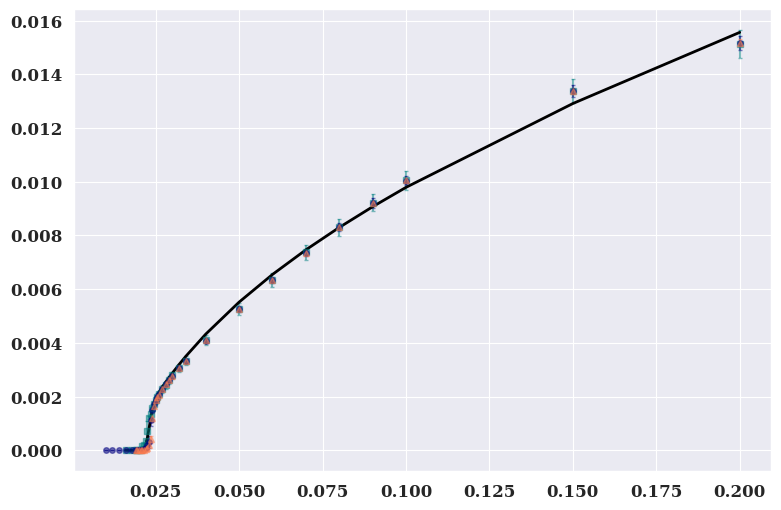

In [223]:
fig, ax = plt.subplots(1,1, figsize = (9,6))

def log_func(x, a, b, c):
    return a * np.log(x) + b*x + c

def logistic_func(x, a, b, c, d, e, f):

    val = a / (1 +  np.exp(-b * (x - c))) * ( d * np.log(x) + e * x + f)
    return val

def bjerrum(x, a, b):
    return a + b *  np.log(x)

for i in range(len(input_paths)):
    act_cutoff_lower_idx = act_list[i].index(act_cutoff_lower)
    ax.errorbar(act_list[i], av_defects[i][:, 0], yerr = av_defects[i][:, 1], fmt = marker_shape[i], label = f'L = {LX[i]}', elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4, alpha=0.5)


ax.plot(act_list[0], logistic_func(np.array(act_list[0]), 1, 1700, 0.023, 0.004, 0.030, 0.016), label = f'L = {LX[0]}', color = 'black')
#ax.set_xlim(0.016, 0.03)
#ax.set_ylim(0, 0.006)


plt.show()

In [180]:
fit_string

'$y = \\frac{{a}}{{1 + e^{{-b(x-c)}}}} \\cdot (d \\ln x + ex + f)$'

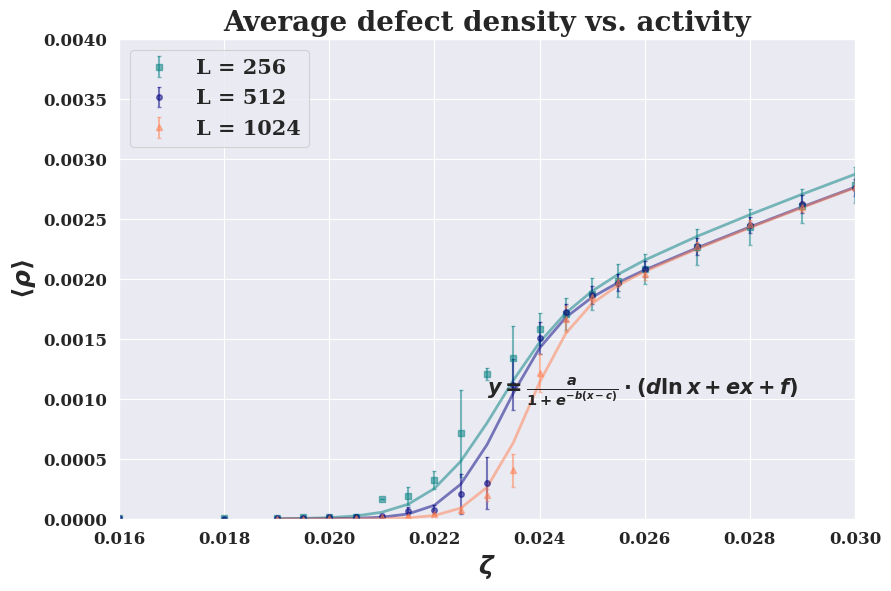

In [229]:
fig, ax = plt.subplots(figsize=(9, 6))
marker_shape = ['s', 'o', '^']
for i in range(len(input_paths)):
    act_cutoff_lower_idx = act_list[i].index(act_cutoff_lower)

    ax.errorbar(act_list[i], av_defects[i][:, 0], yerr = av_defects[i][:, 1], fmt = marker_shape[i], label = f'L = {LX[i]}', elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4, alpha=0.5)
    ax.plot(act_list[i][act_cutoff_lower_idx:], fit_func(np.array(act_list[i][act_cutoff_lower_idx:]), *av_defects_fit[i].values), color = f'C{i}', linewidth=2, alpha=0.5)
ax.legend(loc='upper left')
ax.set_xlabel(r'$\zeta$')
ax.set_ylabel(r'$\langle \rho \rangle$')
ax.set_title('Average defect density vs. activity')
#ax.set_xscale('log')
ax.set_xlim(0.016, 0.03)
ax.set_ylim(0, 0.004)
ax.text(0.5, 0.3, r'$y = \frac{{a}}{{1 + e^{{-b(x-c)}}}} \cdot (d \ln x + ex + f)$', fontsize=15, transform=ax.transAxes,verticalalignment='top')

fig.tight_layout()
plt.show()


In [230]:
LX

array([ 256,  512, 1024])

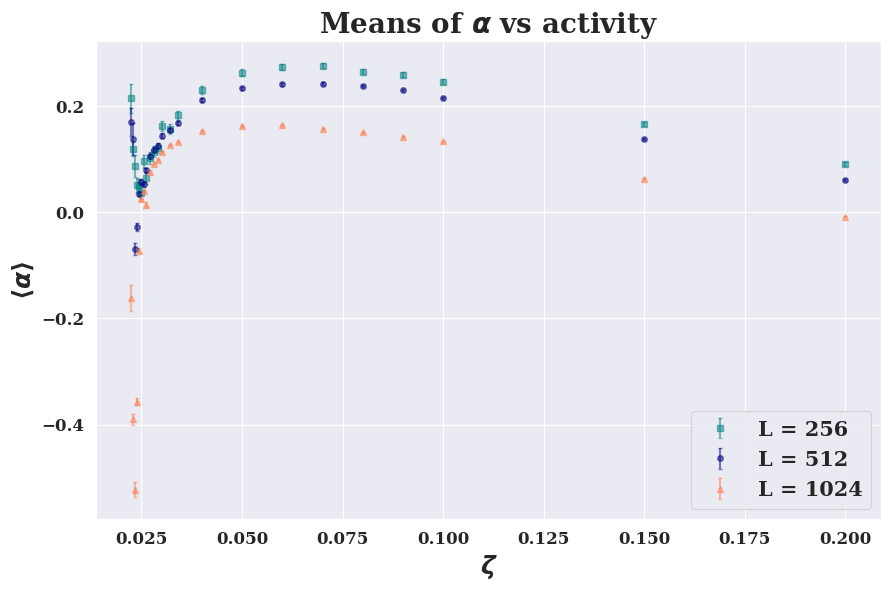

In [231]:
# plot weighted mean and error on mean for all frames and activities
fig2, ax2 = plt.subplots(figsize=(9,6))

for i, act in enumerate(act_list):
        ax2.errorbar(act, hu_fit_params[i][:,0], hu_fit_params[i][:,2], fmt = marker_shape[i], label = f'L = {LX[i]}', elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4, alpha=0.5)

ax2.set_xlabel(r'$\zeta$')
ax2.set_ylabel(r'$\langle \alpha \rangle$')

ax2.set_title(rf'Means of $\alpha $ vs activity')
ax2.legend()
fig2.tight_layout()

In [ ]:
cutoff = 0
for j, windows in enumerate(window_sizes):
    norm = 1 # xi_av[j, act_max_idx]
    
    print("\nWindow size: ", windows)
    print(xi_av[j, cutoff:]/ norm)
    print(xi_av_old[j, cutoff:]/ norm)
    print(act_list[cutoff + np.argmax(xi_av[j,cutoff:] / norm)])
    print(act_list[cutoff + np.argmax(xi_av_old[j,cutoff:] / norm)])

In [226]:
act_list[act_max_idx]

0.021

In [88]:
window_sizes[-10] / window_sizes[-1]

0.394668141252916

C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_4072\1642619186.py:7: RuntimeWarning: Mean of empty slice
  dens_fluc_av2 = np.nanmean(dens_fluc2, axis=3)
c:\Users\Simon Andersen\miniconda3\envs\sf\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


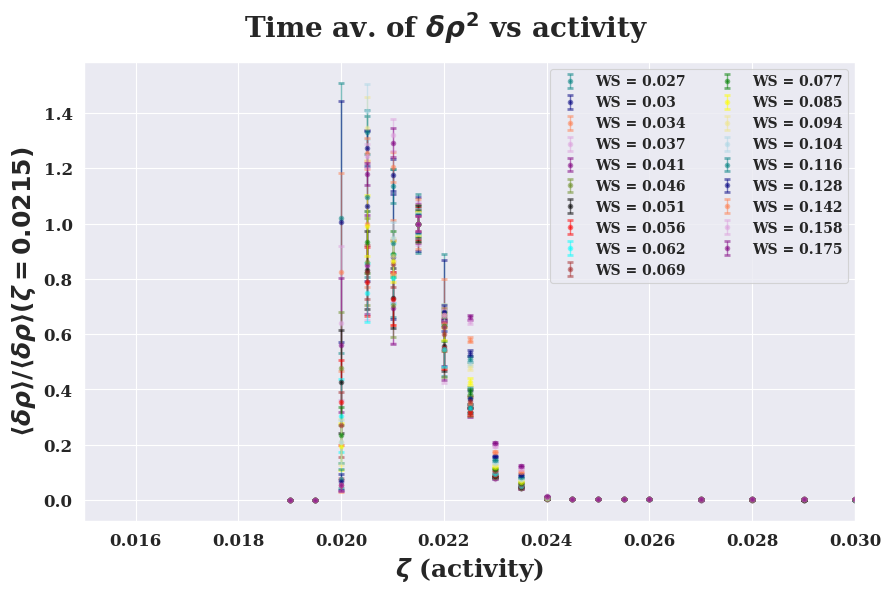

In [94]:
dens_fluc2 = np.load(os.path.join(save_path, 'dens_fluc.npy'))[:, :, :, idx_exp_to_keep_list][:, :, idx_act_to_keep_list, :]
dens_fluc2 = dens_fluc2 * exp_conv_list.T[np.newaxis, np.newaxis, :Nactivity, :]

av_dens_arr = defect_arr
dens_fluc2 = dens_fluc2 / av_dens_arr[:, None, :, :] ** 2

dens_fluc_av2 = np.nanmean(dens_fluc2, axis=3)
dens_fluc_std2 = np.nanstd(dens_fluc2, axis=3, ddof=1) / (np.sqrt(np.nanmean(exp_conv_list, axis=0))[:Nactivity])[None, None, :]

if 0:
    av_density_all_windows2 = av_defects_conv[:, 0] 
    dens_fluc_av2 = dens_fluc_av2 / av_density_all_windows2[:, None, :] ** 2
    dens_fluc_std2 = dens_fluc_std2 / av_density_all_windows2[:, None, :] ** 2

logplot = False

xi_av_old = np.nanmean(dens_fluc_av, axis = 0)
xi_std_old = np.nanstd(dens_fluc_av, axis = 0, ddof=1) / np.sqrt(Nframes_non_nan_counts[np.newaxis, :])

xi_av =  np.nanmean(dens_fluc_av2, axis = 0) #* window_sizes[:, None]**2  #** 2
xi_std = np.nanstd(dens_fluc_av2, axis = 0, ddof=1) / np.sqrt(Nframes_non_nan_counts[np.newaxis, :]) #* window_sizes[:, None]**2 #** 2

fig, ax = plt.subplots(figsize=(9,6))

min_act_cutoff_idx = 0
min_window_cutoff_idx = 3
max_window_cutoff_idx = -8
act_max_idx = act_list.index(0.0215)

for j, window in enumerate(window_sizes[min_window_cutoff_idx:]):
        if window >= window_sizes[max_window_cutoff_idx]:
             continue
        norm = xi_av[j + min_window_cutoff_idx, act_max_idx]
        if j % 1 == 0: #in [1,2,3,4,5,6,7]:
            ax.errorbar(act_list[min_act_cutoff_idx:], xi_av[j + min_window_cutoff_idx, min_act_cutoff_idx:] / norm,\
                            xi_std[j + min_window_cutoff_idx, min_act_cutoff_idx:] / norm, label=f'WS = {np.round(window / 256,3)}', fmt='.', \
                   capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4)

ax.set_xlabel(rf'$\zeta$ (activity)')
ax.set_ylabel(rf'$\langle \delta \rho \rangle / \langle \delta \rho \rangle (\zeta = {act_list[act_max_idx]}) $')
ax.set_xlim(0.015,0.03)

if logplot:
  #  ax.set_yscale('log')
    ax.set_xscale('log')

#add legend above the plot in 3 rows
ax.legend(loc='upper right', ncol=2, fontsize = 10,)
fig.suptitle(rf'Time av. of $\delta \rho ^2$ vs activity', fontsize=20)
fig.tight_layout()
plt.show()

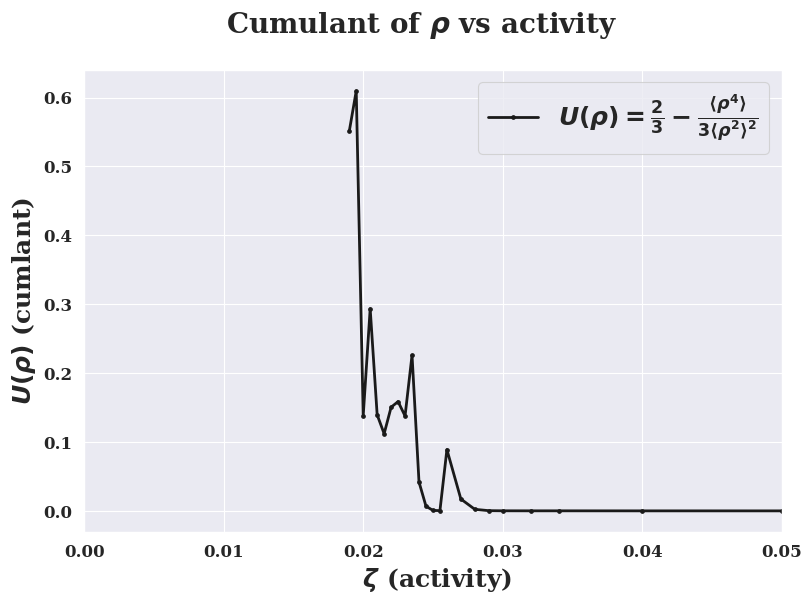

In [93]:
binder_tot = 1 - np.nanmean(np.nanmean(defect_arr[:,:,:] ** 4, axis = -1), axis = 0) \
  / (3 * np.nanmean(np.nanmean(defect_arr[:,:,:] ** 2, axis = -1), axis = 0) ** 2)


# save
np.save(os.path.join(save_path, f'binder_cumulants.npy'), binder_tot)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(act_list, 2/3 - binder_tot, 'k.-', label=r'$U(\rho) = \frac{2}{3} - \frac{\langle \rho^4 \rangle}{3 \langle \rho^2 \rangle ^2}$')

ax.set_xlim(0, 0.05)
ax.set_xlabel(r' $\zeta$ (activity)')
ax.set_ylabel(r'$U(\rho)$ (cumlant)')
ax.legend(loc='upper right', ncol=2, fontsize = 18)
fig.suptitle(rf'Cumulant of $\rho$ vs activity', fontsize=20)

plt.show()